In [100]:
import sys
sys.path.insert(1, "..")
import pprint
import gpytorch
import torch
import numpy as np
import metrics
import copy
import configparser
from experiment_functions import Experiment
from GaussianProcess import ExactGPModel
from globalParams import options, hyperparameter_limits
import gpytorch
from helpFunctions import get_string_representation_of_kernel as gsr
from helpFunctions import clean_kernel_expression
from helpFunctions import get_kernels_in_kernel_expression
from helpFunctions import amount_of_base_kernels
from itertools import product
import json
from kernelSearch import *
from matplotlib import pyplot as plt
from metrics import *
from multiprocessing import Pool
import numpy as np
import os
import pdb
import pickle
import random
import tikzplotlib
import time
import torch
from tqdm import tqdm
from scipy.stats import multivariate_normal
import matplotlib as mpl

# To run STAN in a Jupyter notebook
import nest_asyncio
nest_asyncio.apply()

# Helper functions

In [101]:

def log_prior(model, theta_mu=None, sigma=None):
    # params -
    # TODO de-spaghettize this once the priors are coded properly
    prior_dict = {'SE': {'raw_lengthscale' : {"mean": -0.21221139138922668 , "std":1.8895426067756804}},
                  'MAT52': {'raw_lengthscale' :{"mean": 0.7993038925994188, "std":2.145122566357853 } },
                  'MAT32': {'raw_lengthscale' :{"mean": 1.5711054238673443, "std":2.4453761235991216 } },
                  'RQ': {'raw_lengthscale' :{"mean": -0.049841950913676276, "std":1.9426354614713097 },
                          'raw_alpha' :{"mean": 1.882148553921053, "std":3.096431944989054 } },
                  'PER':{'raw_lengthscale':{"mean": 0.7778461197268618, "std":2.288946656544974 },
                          'raw_period_length':{"mean": 0.6485334993738499, "std":0.9930632050553377 } },
                  'LIN':{'raw_variance' :{"mean": -0.8017903983055685, "std":0.9966569921354465 } },
                  'c':{'raw_outputscale':{"mean": -1.6253091096349706, "std":2.2570021716661923 } },
                  'noise': {'raw_noise':{"mean": -3.51640656386717, "std":3.5831320474767407 }}}
    #prior_dict = {"SE": {"raw_lengthscale": {"mean": 0.891, "std": 2.195}},
    #              "MAT": {"raw_lengthscale": {"mean": 1.631, "std": 2.554}},
    #              "PER": {"raw_lengthscale": {"mean": 0.338, "std": 2.636},
    #                      "raw_period_length": {"mean": 0.284, "std": 0.902}},
    #              "LIN": {"raw_variance": {"mean": -1.463, "std": 1.633}},
    #              "c": {"raw_outputscale": {"mean": -2.163, "std": 2.448}},
    #              "noise": {"raw_noise": {"mean": -1.792, "std": 3.266}}}

    variances_list = list()
    debug_param_name_list = list()
    theta_mu = list()
    params = list()
    covar_string = gsr(model.covar_module)
    covar_string = covar_string.replace("(", "")
    covar_string = covar_string.replace(")", "")
    covar_string = covar_string.replace(" ", "")
    covar_string = covar_string.replace("PER", "PER+PER")
    covar_string_list = [s.split("*") for s in covar_string.split("+")]
    covar_string_list.insert(0, ["LIKELIHOOD"])
    covar_string_list = list(chain.from_iterable(covar_string_list))
    both_PER_params = False
    for (param_name, param), cov_str in zip(model.named_parameters(), covar_string_list):
        params.append(param.item())
        debug_param_name_list.append(param_name)
        # First param is (always?) noise and is always with the likelihood
        if "likelihood" in param_name:
            theta_mu.append(prior_dict["noise"]["raw_noise"]["mean"])
            variances_list.append(prior_dict["noise"]["raw_noise"]["std"])
            continue
        else:
            if (cov_str == "PER" or cov_str == "RQ") and not both_PER_params:
                theta_mu.append(prior_dict[cov_str][param_name.split(".")[-1]]["mean"])
                variances_list.append(prior_dict[cov_str][param_name.split(".")[-1]]["std"])
                both_PER_params = True
            elif (cov_str == "PER" or cov_str == "RQ") and both_PER_params:
                theta_mu.append(prior_dict[cov_str][param_name.split(".")[-1]]["mean"])
                variances_list.append(prior_dict[cov_str][param_name.split(".")[-1]]["std"])
                both_PER_params = False
            else:
                try:
                    theta_mu.append(prior_dict[cov_str][param_name.split(".")[-1]]["mean"])
                    variances_list.append(prior_dict[cov_str][param_name.split(".")[-1]]["std"])
                except Exception as E:
                    import pdb
                    pdb.set_trace()
                    prev_cov = cov_str
    theta_mu = torch.tensor(theta_mu)
    theta_mu = theta_mu.unsqueeze(0).t()
    sigma = torch.diag(torch.Tensor(variances_list))
    sigma = sigma@sigma
    prior = torch.distributions.MultivariateNormal(theta_mu.t(), sigma)

    # for convention reasons I'm diving by the number of datapoints
    return prior.log_prob(torch.Tensor(params)).item() / len(*model.train_inputs)

def optimize_hyperparameters(model, likelihood, train_iterations, X, Y, with_BFGS=False, MAP=False, prior=None, **kwargs):
    """
    find optimal hyperparameters either by BO or by starting from random initial values multiple times, using an optimizer every time
    and then returning the best result
    """
    ## Setup
    # Log the parameters found during training
    log_param_path = kwargs.get("log_param_path", False)
    log_likelihood = kwargs.get("log_likelihood", False)
    random_restarts = kwargs.get("random_restarts", options["training"]["restarts"]+1)
    best_loss = 1e400
    optimal_parameters = dict()
    limits = hyperparameter_limits
    if log_param_path:
        param_log_list = list()
    if log_likelihood:
        likelihood_logs = list()
    # start runs
    for iteration in range(random_restarts):
    #for iteration in range(2):
        if log_likelihood:
            likelihood_log = list()
        if log_param_path:
            param_log_dict = {param_name[0] : list() for param_name in model.named_parameters()}
        # optimize and determine loss
        # Perform a training for AIC and Laplace
        model.train()
        likelihood.train()

        optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

        for i in range(train_iterations):
            # Zero gradients from previous iteration
            optimizer.zero_grad()
            # Output from model
            output = model(X)
            # Calc loss and backprop gradients
            loss = -mll(output, Y)
            if MAP:
                log_p = log_prior(model)
                loss -= log_p
            loss.backward()
            optimizer.step()
            if log_param_path:
                for param_name in model.named_parameters():
                    param_log_dict[param_name[0]].append(param_name[1].item())
            if log_likelihood:
                likelihood_log.append(loss.item())

        if with_BFGS:
            # Additional BFGS optimization to better ensure optimal parameters
            # LBFGS_optimizer = torch.optim.LBFGS(model.parameters(), max_iter=50, line_search_fn='strong_wolfe')
            LBFGS_optimizer = torch.optim.LBFGS(
                model.parameters(), max_iter=50,
                line_search_fn='strong_wolfe')
            # define closure

            def closure():
                LBFGS_optimizer.zero_grad()
                output = model(X)
                loss = -mll(output, Y)
                if MAP:
                    log_p = log_prior(model)
                    loss -= log_p
                LBFGS_optimizer.zero_grad()
                loss.backward()
                if log_param_path:
                    for param_name in model.named_parameters():
                        param_log_dict[param_name[0]].append(param_name[1].item())
                if log_likelihood:
                    likelihood_log.append(loss.item())
                return loss
            LBFGS_optimizer.step(closure)

        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(X)
        # Calc loss and backprop gradients
        loss = -mll(output, Y)
        if MAP:
            log_p = log_prior(model)
            loss -= log_p

#        model.train_model(with_BFGS=with_BFGS)
        current_loss = loss
        # check if the current run is better than previous runs
        if current_loss < best_loss:
            # if it is the best, save all used parameters
            best_loss = current_loss
            for param_name, param in model.named_parameters():
                optimal_parameters[param_name] = copy.deepcopy(param)

        # set new random inital values
        model.likelihood.noise_covar.noise = torch.rand(1) * (limits["Noise"][1] - limits["Noise"][0]) + limits["Noise"][0]
        #self.mean_module.constant = torch.rand(1) * (limits["Mean"][1] - limits["Mean"][0]) + limits["Mean"][0]
        for kernel in get_kernels_in_kernel_expression(model.covar_module):
            hypers = limits[kernel._get_name()]
            for hyperparameter in hypers:
                new_value = torch.rand(1) * (hypers[hyperparameter][1] - hypers[hyperparameter][0]) + hypers[hyperparameter][0]
                setattr(kernel, hyperparameter, new_value)

        # print output if enabled
        if options["training"]["print_optimizing_output"]:
            print(f"HYPERPARAMETER OPTIMIZATION: Random Restart {iteration}: loss: {current_loss}, optimal loss: {best_loss}")
        if log_likelihood:
            likelihood_logs.append(likelihood_log)
        if log_param_path:
            param_log_list.append(param_log_dict)

    # finally, set the hyperparameters those in the optimal run
    model.initialize(**optimal_parameters)
    output = model(X)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    loss = -mll(output, Y)
    if MAP:
        log_p = log_prior(model)
        loss -= log_p
    if not loss == best_loss:
        import pdb
        pdb.set_trace()
        print(loss)
        print(best_loss)
    logables = dict()
    if log_param_path:
        logables["training_log"] = param_log_dict
    if log_likelihood:
        logables["likelihood_log"] = likelihood_log
    if len(logables.keys()) > 0:
        return loss, logables
    return loss

In [102]:
def get_std_points(mu, K):
    x, y = np.mgrid[-3:3:.1, -3:3:.1]
    rv = multivariate_normal(mu, K)
    L = np.linalg.cholesky(K)

    data = np.dstack((x, y))
    z = rv.pdf(data)

    # Drawing the unit circle
    # x^2 + y^2 = 1
    precision = 50
    unit_x = torch.cat([torch.linspace(-1, 1, precision), torch.linspace(-1, 1, precision)])
    unit_y = torch.cat([torch.sqrt(1 - torch.linspace(-1, 1, precision)**2), -torch.sqrt(1 - torch.linspace(-1, 1, precision)**2)])

    new_unit_x = list()
    new_unit_y = list()

    for tx, ty in zip(unit_x, unit_y):
        res = np.array([tx, ty]) @ L
        new_unit_x.append(mu[0] + 2*res[0])
        new_unit_y.append(mu[1] + 2*res[1])
    return new_unit_x, new_unit_y

# Pre-diddling

In [103]:
# Globals
figure_path = "linear_figures"

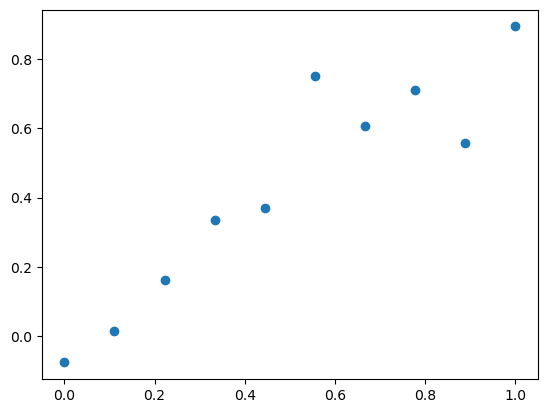

In [104]:
END = 1
COUNT = 10
train_x = torch.linspace(0, END, COUNT)
train_y = torch.linspace(0, END, COUNT)
train_y += torch.randn(train_x.size()) * torch.tensor(0.1)
plt.plot(train_x, train_y, "o")

# Model definition

In [105]:
# Simplest GP possible. SE with constant sigma_f 
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.RBFKernel()
        #self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel())
        #self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [106]:
print(torch.linalg.eigh(model(train_x).covariance_matrix)[0].flip(0))
print(model(train_x).covariance_matrix)

tensor([ 8.3621e+00,  1.5041e+00,  1.2708e-01,  6.5276e-03,  2.2986e-04,
         5.6375e-06,  2.2122e-07,  3.9967e-08, -2.4226e-08, -8.4223e-08],
       grad_fn=<FlipBackward0>)
tensor([[1.0000, 0.9872, 0.9499, 0.8908, 0.8142, 0.7253, 0.6297, 0.5328, 0.4394,
         0.3532],
        [0.9872, 1.0000, 0.9872, 0.9499, 0.8908, 0.8142, 0.7253, 0.6297, 0.5328,
         0.4394],
        [0.9499, 0.9872, 1.0000, 0.9872, 0.9499, 0.8908, 0.8142, 0.7253, 0.6297,
         0.5328],
        [0.8908, 0.9499, 0.9872, 1.0000, 0.9872, 0.9499, 0.8908, 0.8142, 0.7253,
         0.6297],
        [0.8142, 0.8908, 0.9499, 0.9872, 1.0000, 0.9872, 0.9499, 0.8908, 0.8142,
         0.7253],
        [0.7253, 0.8142, 0.8908, 0.9499, 0.9872, 1.0000, 0.9872, 0.9499, 0.8908,
         0.8142],
        [0.6297, 0.7253, 0.8142, 0.8908, 0.9499, 0.9872, 1.0000, 0.9872, 0.9499,
         0.8908],
        [0.5328, 0.6297, 0.7253, 0.8142, 0.8908, 0.9499, 0.9872, 1.0000, 0.9872,
         0.9499],
        [0.4394, 0.5328, 0.62

# Training

In [107]:
num_train_iter = 100
use_MAP = True 
use_LBFGS = True
# Train the MAP for 100 Iterations of ADAM and then 50 more of L-BFGS
loss, training_log = optimize_hyperparameters(model, likelihood, num_train_iter, train_x, train_y, use_LBFGS, MAP=use_MAP, log_param_path=True, random_restarts=1, log_likelihood=True)

In [108]:
print(torch.linalg.eigh(model(train_x).covariance_matrix)[0].flip(0))
print(model(train_x).covariance_matrix)

tensor([ 9.2975e+00,  6.8118e-01,  2.0929e-02,  3.8886e-04,  4.8761e-06,
         2.5574e-07, -6.7280e-09, -2.9357e-08, -1.0489e-07, -1.7071e-07],
       grad_fn=<FlipBackward0>)
tensor([[1.0000, 0.9953, 0.9813, 0.9584, 0.9273, 0.8887, 0.8438, 0.7936, 0.7394,
         0.6824],
        [0.9953, 1.0000, 0.9953, 0.9813, 0.9584, 0.9273, 0.8887, 0.8438, 0.7936,
         0.7394],
        [0.9813, 0.9953, 1.0000, 0.9953, 0.9813, 0.9584, 0.9273, 0.8887, 0.8438,
         0.7936],
        [0.9584, 0.9813, 0.9953, 1.0000, 0.9953, 0.9813, 0.9584, 0.9273, 0.8887,
         0.8438],
        [0.9273, 0.9584, 0.9813, 0.9953, 1.0000, 0.9953, 0.9813, 0.9584, 0.9273,
         0.8887],
        [0.8887, 0.9273, 0.9584, 0.9813, 0.9953, 1.0000, 0.9953, 0.9813, 0.9584,
         0.9273],
        [0.8438, 0.8887, 0.9273, 0.9584, 0.9813, 0.9953, 1.0000, 0.9953, 0.9813,
         0.9584],
        [0.7936, 0.8438, 0.8887, 0.9273, 0.9584, 0.9813, 0.9953, 1.0000, 0.9953,
         0.9813],
        [0.7394, 0.7936, 0.84

In [109]:
print(f"{'MAP' if use_MAP else 'likelihood'}:{loss}")
print(list(model.named_parameters()))

MAP:0.20389863848686218
[('likelihood.noise_covar.raw_noise', Parameter containing:
tensor([-4.2555], requires_grad=True)), ('covar_module.raw_lengthscale', Parameter containing:
tensor([[0.7602]], requires_grad=True))]


In [110]:
model.likelihood.noise

tensor([0.0142], grad_fn=<AddBackward0>)

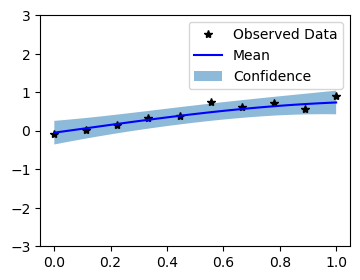

In [124]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    a = model(test_x)
    observed_pred = likelihood(a)
    
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

In [112]:
observed_pred.confidence_region()

(tensor([-0.3549, -0.3269, -0.2994, -0.2723, -0.2458, -0.2198, -0.1942, -0.1691,
         -0.1444, -0.1202, -0.0963, -0.0728, -0.0497, -0.0269, -0.0045,  0.0176,
          0.0393,  0.0608,  0.0820,  0.1028,  0.1234,  0.1436,  0.1635,  0.1831,
          0.2024,  0.2214,  0.2399,  0.2581,  0.2759,  0.2933,  0.3103,  0.3267,
          0.3427,  0.3582,  0.3731,  0.3874,  0.4011,  0.4141,  0.4264,  0.4380,
          0.4488,  0.4587,  0.4678,  0.4759,  0.4831,  0.4893,  0.4944,  0.4984,
          0.5014,  0.5032,  0.5038]),
 tensor([0.2260, 0.2435, 0.2616, 0.2804, 0.2998, 0.3196, 0.3400, 0.3607, 0.3818,
         0.4032, 0.4248, 0.4466, 0.4685, 0.4904, 0.5123, 0.5342, 0.5559, 0.5775,
         0.5989, 0.6200, 0.6408, 0.6614, 0.6815, 0.7013, 0.7207, 0.7397, 0.7582,
         0.7763, 0.7939, 0.8111, 0.8277, 0.8439, 0.8596, 0.8749, 0.8897, 0.9040,
         0.9179, 0.9315, 0.9446, 0.9574, 0.9699, 0.9821, 0.9940, 1.0058, 1.0173,
         1.0287, 1.0400, 1.0512, 1.0624, 1.0735, 1.0847]))

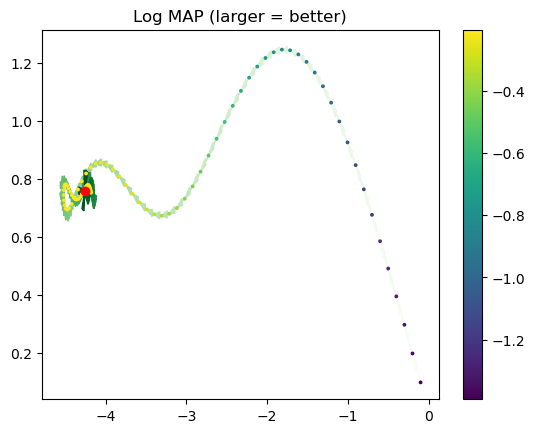

In [113]:
#plt.plot(training_log["training_log"]['likelihood.noise_covar.raw_noise'])
#plt.plot(training_log["likelihood_log"])
param_keys = list(training_log["training_log"].keys())
filtered = False 
filtered_noise = list()
filtered_length = list()
filtered_loglike = list()

# loop to filter draws below X 
for n, l, llik in zip(training_log["training_log"][param_keys[0]], training_log["training_log"][param_keys[1]], training_log["likelihood_log"]):
    if llik > -5000:
        filtered_noise.append(n)
        filtered_length.append(l)
        filtered_loglike.append(llik)

if filtered:
    for i in range(len(filtered_noise)-1):
        n, l = filtered_noise[i], filtered_length[i]
        n2, l2 = filtered_noise[i+1], filtered_length[i+1]
        plt.arrow(n, l, n2-n, l2-l, color=mpl.colormaps["Greens"](i/len(filtered_noise)), head_length = 0.07, head_width = 0.025, length_includes_head = True)
    plt.scatter(filtered_noise, filtered_length, c=filtered_loglike, s=3)
else:
    for i in range(len(training_log["training_log"][param_keys[0]])-1):
        n, l = training_log["training_log"][param_keys[0]][i], training_log["training_log"][param_keys[1]][i]
        n2, l2 = training_log["training_log"][param_keys[0]][i+1], training_log["training_log"][param_keys[1]][i+1]
        plt.arrow(n, l, n2-n, l2-l, color=mpl.colormaps["Greens"](i/len(training_log["training_log"][param_keys[0]])), head_length = 0.07, head_width = 0.025, length_includes_head = True)
    plt.scatter(training_log["training_log"][param_keys[0]], training_log["training_log"][param_keys[1]], c=-torch.Tensor(training_log["likelihood_log"]), s=3)
plt.title("Log MAP (larger = better)" if use_MAP else "Log Likelihood (larger = better)")
plt.colorbar()

plt.plot(training_log["training_log"][param_keys[0]][-1], training_log["training_log"][param_keys[1]][-1], "ro") 


In [114]:
with torch.no_grad():
    observed_pred_prior = likelihood(model(model.train_inputs[0]))

like_cov_chol = torch.linalg.cholesky(observed_pred_prior.covariance_matrix)
like_dist = torch.distributions.multivariate_normal.MultivariateNormal(observed_pred_prior.mean, scale_tril=like_cov_chol)
print(like_dist.log_prob(model.train_targets))
print(-training_log["likelihood_log"][-1]*COUNT)
print(-loss*COUNT)

tensor(7.5079)
-2.038986384868622
tensor(-2.0390, grad_fn=<MulBackward0>)


/home/besginow/anaconda3/envs/sage/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:274: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


# Laplace

L-BFGS iterations: 8
tensor(-2.2040, dtype=torch.float64, grad_fn=<AddBackward0>)
{'neg MLL': tensor(0.2039, grad_fn=<NegBackward0>), 'punish term': tensor(-2.0001, dtype=torch.float64), 'laplace without replacement': tensor(3.1529, dtype=torch.float64, grad_fn=<SubBackward0>), 'num_replaced': tensor(2), 'parameter list': ['likelihood.noise_covar.raw_noise', 'covar_module.raw_lengthscale'], 'Jacobian': (tensor([-1.7962e-05], grad_fn=<SoftplusBackwardBackward0>), tensor([[-5.5987e-05]], grad_fn=<SoftplusBackwardBackward0>)), 'parameter values': tensor([[-4.2555],
        [ 0.7602]]), 'corrected Hessian': tensor([[ 4.6427e+01, -4.4409e-16],
        [ 4.4409e-16,  4.6427e+01]], dtype=torch.float64), 'diag(constructed eigvals)': tensor([46.4268, 46.4268], dtype=torch.float64), 'original symmetrized Hessian': tensor([[ 0.3566, -0.0108],
        [-0.0108,  0.1347]], dtype=torch.float64), 'prior mean': tensor([[-3.5164],
        [-0.2122]], dtype=torch.float64), 'diag(prior var)': tensor([12.

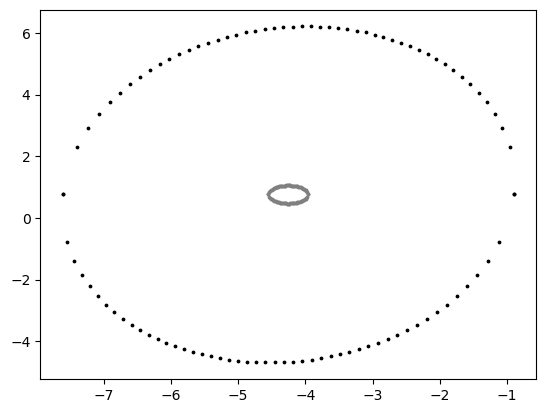

In [115]:
print(f"L-BFGS iterations: {len(training_log['likelihood_log']) - num_train_iter}")

lap, lap_log = metrics.calculate_laplace(model, -loss, with_prior=True, param_punish_term=-1.0)
print(lap)
print(lap_log)

# Draw the distribution defined by the mean (found parametrization) and covariance matrix (Hessian)
# (4.133) in Bishop, 2006: f(z) ~ f(z_0)exp(-0.5 (z-z_0)^T H (z-z_0)) with z the parameters, and H the Hessian
# We just leave out the f(z_0)

scaling_factor = lap_log["neg MLL"]
mu = [training_log["training_log"][param_keys[0]][-1], training_log["training_log"][param_keys[1]][-1]]
K = lap_log["corrected Hessian"]
new_unit_x, new_unit_y = get_std_points(mu, K.inverse()[:2, :2])
plt.scatter(new_unit_x, new_unit_y, color="grey", s=3)
K = lap_log["original symmetrized Hessian"]
new_unit_x, new_unit_y = get_std_points(mu, K.inverse()[:2, :2])
plt.scatter(new_unit_x, new_unit_y, color="black", s=3)



In [116]:
torch.linalg.eigh(torch.tensor([[0.0453, 0.0083],
        [0.0083, 0.0205]]))

torch.return_types.linalg_eigh(
eigenvalues=tensor([0.0180, 0.0478]),
eigenvectors=tensor([[ 0.2907, -0.9568],
        [-0.9568, -0.2907]]))

# MCMC

In [117]:
from metrics import calculate_mc_STAN
# Perform MCMC
MCMC_approx, MC_log = calculate_mc_STAN(
    model, likelihood, 1000, log_param_path=True, log_full_likelihood=True)
print(MCMC_approx)

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_s_8ch4oo/model_h65mczj6.stan', line 5, column 12: A
    control flow statement inside function softplus depends on argument v. At
    '/tmp/httpstan_s_8ch4oo/model_h65mczj6.stan', line 33, column 97 to
    column 105, the value of v depends on parameter(s): theta.
Warning in '/tmp/httpstan_s_8ch4oo/model_h65mczj6.stan', line 5, column 12: A
    control flow statement inside function softplus depends on argument v. At
    '/tmp/httpstan_s_8ch4oo/model_h65mczj6.stan', line 33, column 51 to
    column 59, the value of v depends on parameter(s): theta.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100% (2000/2000)
Sampling: 100% (2000/2000), done.
Messages received during sampling:
  Gradient evaluation took 1.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.14 seconds.
  Adjust your expect

tensor(-31.8953)


In [118]:
# w. 0 ADAM (MAP)
#[('likelihood.noise_covar.raw_noise', Parameter containing:
#tensor([-11.8925], requires_grad=True)), ('covar_module.raw_lengthscale', Parameter containing:
#tensor([[1.7432]], requires_grad=True))]
# w. 50 ADAM
# [('likelihood.noise_covar.raw_noise', Parameter containing:
# tensor([-11.6812], requires_grad=True)), ('covar_module.raw_lengthscale', Parameter containing:
# tensor([[1.5973]], requires_grad=True))]
# w. 100 ADAM
# [('likelihood.noise_covar.raw_noise', Parameter containing:
# tensor([-10.8088], requires_grad=True)), ('covar_module.raw_lengthscale', Parameter containing:
# tensor([[1.8571]], requires_grad=True))]

#max_index = MC_log['manual lp list'].index(max(MC_log['manual lp list']))
#for i, param in enumerate(MC_log['param draws dict']):
#    print(f"{lap_log['parameter list'][i]}:{MC_log['param draws dict'][param][max_index]}")

{'mu': tensor([[-3.5164],
        [-0.2122]]), 'var': tensor([[12.8388,  0.0000],
        [ 0.0000,  3.5704]])}


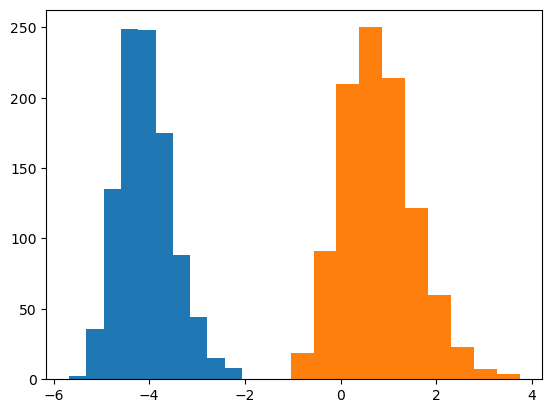

In [119]:


for param_name in MC_log['param draws dict']:
    plt.hist(MC_log['param draws dict'][param_name])
print(MC_log["Parameter prior"])
plt.savefig(f"{figure_path}/MCMC_param_distribution_{COUNT}_datapoints.png")

Text(0.5, 1.0, 'Log Likelihood')

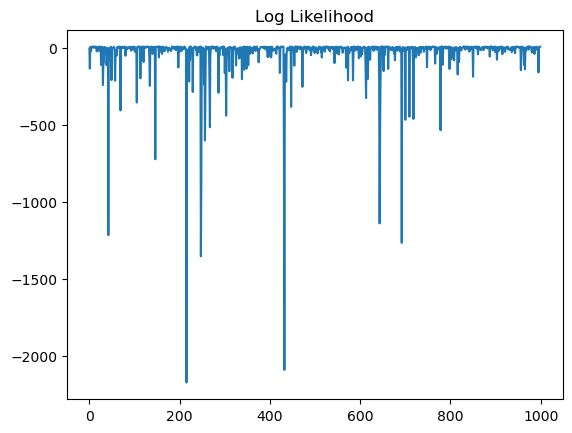

In [120]:
plt.plot(MC_log['manual lp list'])
plt.title("Log Likelihood")

In [135]:
print(MC_log["Parameter statistics"])

mu = [training_log["training_log"][param_keys[0]][-1], training_log["training_log"][param_keys[1]][-1]]
K = lap_log["corrected Hessian"]
print(f"{[training_log['training_log'][param_key][-1] for param_key in param_keys]}")
print(f"{K.inverse().diag()}")

{'theta.1': {'mu': -4.066906254392502, 'var': 0.31806983047659526}, 'theta.2': {'mu': 0.8038986742136048, 'var': 0.5814957187679123}}
[-4.255513668060303, 0.7602176666259766]
tensor([0.0215, 0.0215], dtype=torch.float64)


['likelihood.noise_covar.raw_noise', 'covar_module.raw_lengthscale']

Text(0.5, 1.0, 'Log Likelihood')

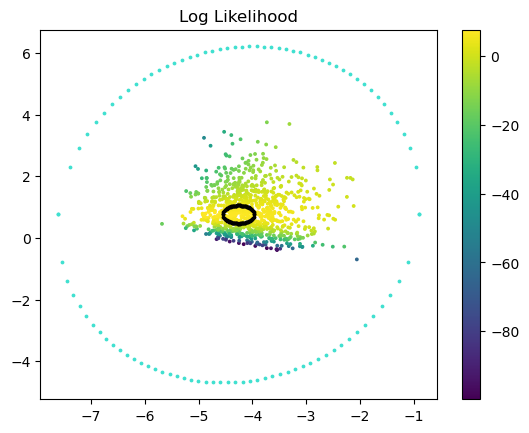

In [122]:
#
#scaling_factor = lap_log["neg MLL"]
#mu = [training_log["training_log"][param_keys[0]][-1], training_log["training_log"][param_keys[1]][-1]]
#K = lap_log["corrected Hessian"]
#new_unit_x, new_unit_y = get_std_points(mu, K)
##plt.scatter(new_unit_x, new_unit_y, color="grey", s=3)
#K = lap_log["original symmetrized Hessian"]
#new_unit_x, new_unit_y = get_std_points(mu, K)
#plt.scatter(new_unit_x, new_unit_y, color="black", s=3)
#

filtered = True 
filtered_noise = list()
filtered_length = list()
filtered_loglike = list()

# loop to filter draws below X 
for n, l, llik in zip(MC_log['param draws dict']["theta.1"], MC_log['param draws dict']["theta.2"], MC_log['manual lp list']):
    if llik > -100:
        filtered_noise.append(n)
        filtered_length.append(l)
        filtered_loglike.append(llik)

if filtered:
    for i in range(len(filtered_noise)-1):
        n, l = filtered_noise[i], filtered_length[i]
        n2, l2 = filtered_noise[i+1], filtered_length[i+1]
        #plt.arrow(n, l, n2-n, l2-l, color=mpl.colormaps["Greens"](i/len(filtered_noise)), head_length = 0.07, head_width = 0.025, length_includes_head = True)
    plt.scatter(filtered_noise, filtered_length, c=filtered_loglike, s=3)
    max_index = MC_log['manual lp list'].index(max(MC_log['manual lp list']))
    #plt.plot(MC_log['param draws dict']["theta.1"][max_index], MC_log['param draws dict']["theta.2"][max_index], "ro")
else:
    for i in range(len(MC_log['param draws dict']["theta.1"])-1):
        n, l = MC_log['param draws dict']["theta.1"][i], MC_log['param draws dict']["theta.2"][i]
        n2, l2 = MC_log['param draws dict']["theta.1"][i+1], MC_log['param draws dict']["theta.2"][i+1]
        #plt.arrow(n, l, n2-n, l2-l, color=mpl.colormaps["Greens"](i/len(MC_log['param draws dict']["theta.1"])), head_length = 0.07, head_width = 0.025, length_includes_head = True)
    plt.scatter(MC_log['param draws dict']["theta.1"], MC_log['param draws dict']["theta.2"], c=torch.Tensor(MC_log['manual lp list']), s=3)
    max_index = MC_log['manual lp list'].index(max(MC_log['manual lp list']))
    plt.plot(MC_log['param draws dict']["theta.1"][max_index], MC_log['param draws dict']["theta.2"][max_index], "ro")

plt.colorbar() 

mu = [training_log["training_log"][param_keys[0]][-1], training_log["training_log"][param_keys[1]][-1]]
K = lap_log["corrected Hessian"]
new_unit_x, new_unit_y = get_std_points(mu, K.inverse()[:2, :2])
plt.scatter(new_unit_x, new_unit_y, color="black", s=3)

K = lap_log["original symmetrized Hessian"]
new_unit_x, new_unit_y = get_std_points(mu, K.inverse()[:2, :2])
plt.scatter(new_unit_x, new_unit_y, color="turquoise", s=3)
plt.title("Log Likelihood")


Text(0.5, 1.0, 'Log Likelihood')

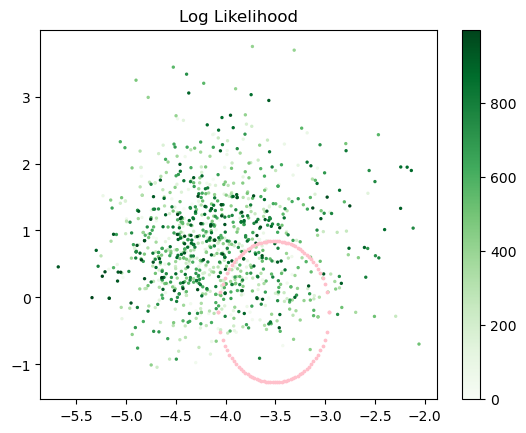

In [123]:
# Contour plot of the likelihood surface according to the explored samples
# loop to filter draws below -5000
filtered_noise = list()
filtered_length = list()
filtered_loglike = list()
for n, l, llik in zip(MC_log['param draws dict']["theta.1"], MC_log['param draws dict']["theta.2"], MC_log['manual lp list']):
    if llik > -5000:
        filtered_noise.append(n)
        filtered_length.append(l)
        filtered_loglike.append(llik)
plt.scatter(MC_log['param draws dict']["theta.1"], MC_log['param draws dict']["theta.2"], c=range(len(MC_log['param draws dict']["theta.2"])), cmap="Greens", s=2)
plt.colorbar() 
## Drawing the parameter Prior
new_unit_x, new_unit_y = get_std_points(MC_log["Parameter prior"]["mu"].numpy().T[0][:2], MC_log["Parameter prior"]["var"].inverse()[:2, :2])
# Draw one standard deviation around the center of the distribution
plt.scatter(new_unit_x, new_unit_y, color="pink", s=3)
#plt.scatter(filtered_noise, filtered_length, c=filtered_loglike)



plt.title("Log Likelihood")